In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyspark as ps 
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Imputer
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor

%matplotlib inline

spark = ps.sql.SparkSession.builder.master("local")\
                                    .appName("casestudy-taxi")\
                                    .getOrCreate()

In [4]:
#bucket = 'arn:aws:s3:::nyc-tlc'
# connect to s3 bucket with bucket
bucket = 'nyc-tlc'

import boto3
s3 = boto3.client('s3')
all_objects = s3.list_objects(Bucket = bucket)
                    

In [5]:
all_objects

{'Contents': [{'ETag': '"d41d8cd98f00b204e9800998ecf8427e"',
   'Key': 'misc/',
   'LastModified': datetime.datetime(2016, 8, 17, 14, 54, 39, tzinfo=tzutc()),
   'Owner': {'DisplayName': 'research',
    'ID': '418251095389ec36f4cc533b768d7363d30d0d38f95cde3867c204468c39861d'},
   'Size': 0,
   'StorageClass': 'STANDARD'},
  {'ETag': '"f21b9424ed28661676114566b3cf6449-34"',
   'Key': 'misc/FOIL_2017-12-04.csv',
   'LastModified': datetime.datetime(2017, 12, 5, 19, 45, 41, tzinfo=tzutc()),
   'Owner': {'DisplayName': 'research',
    'ID': '418251095389ec36f4cc533b768d7363d30d0d38f95cde3867c204468c39861d'},
   'Size': 555893670,
   'StorageClass': 'STANDARD'},
  {'ETag': '"5636ce293220f02da6615cefd86a0683-61"',
   'Key': 'misc/FOIL_fhv_trips_june17.csv',
   'LastModified': datetime.datetime(2018, 4, 5, 19, 12, 3, tzinfo=tzutc()),
   'Owner': {'DisplayName': 'research',
    'ID': '418251095389ec36f4cc533b768d7363d30d0d38f95cde3867c204468c39861d'},
   'Size': 1009693945,
   'StorageClass': 

In [58]:
# download a green file 
key_green = 'trip data/green_tripdata_2014-01.csv'
key_fhv = 'trip data/fhv_tripdata_2015-06.csv'
key_yellow = 'trip data/yellow_tripdata_2015-07.csv'
#fhv_object = s3.get_object(Bucket = bucket, Key = key_fhv)

In [59]:
#green_object

In [60]:
#body = fhv_object['Body'].read() # this works but real slow, reads to memory

In [61]:
# Download the file from S3 
try:
    s3.download_file(bucket, key_yellow, 'yellow_test.csv')
except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == '484':
            print('the object does not exist')
        else:
            raise

In [118]:
f's3://{bucket}/{key_yellow}'

's3://nyc-tlc/trip data/yellow_tripdata_2012-11.csv'

In [119]:
df = spark.read.csv(f's3a://{bucket}/{key_yellow}')

In [121]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)



In [62]:
# read into pandas
test_df = pd.read_csv('yellow_test.csv',nrows=50000)

In [63]:
test_df.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude', 'rate_code',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount',
       'tolls_amount', 'total_amount'],
      dtype='object')

In [64]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
vendor_id             50000 non-null object
pickup_datetime       50000 non-null object
dropoff_datetime      50000 non-null object
passenger_count       50000 non-null int64
trip_distance         50000 non-null float64
pickup_longitude      50000 non-null float64
pickup_latitude       50000 non-null float64
rate_code             50000 non-null int64
store_and_fwd_flag    27521 non-null object
dropoff_longitude     50000 non-null float64
dropoff_latitude      50000 non-null float64
payment_type          50000 non-null object
fare_amount           50000 non-null float64
surcharge             50000 non-null float64
mta_tax               50000 non-null float64
tip_amount            50000 non-null float64
tolls_amount          50000 non-null float64
total_amount          50000 non-null float64
dtypes: float64(11), int64(2), object(5)
memory usage: 6.9+ MB


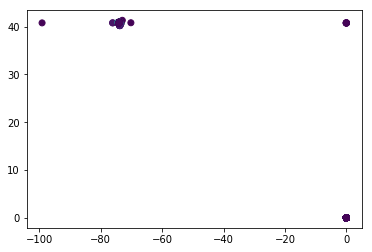

In [42]:
#pd.plotting.scatter_matrix(test_df, alpha=0.2, figsize=(6, 6), diagonal='kde')

In [76]:
# clean zero vals out of lat, long
clean_df = test_df[(test_df.pickup_latitude > 0) & (abs(test_df.pickup_longitude) > 0)]


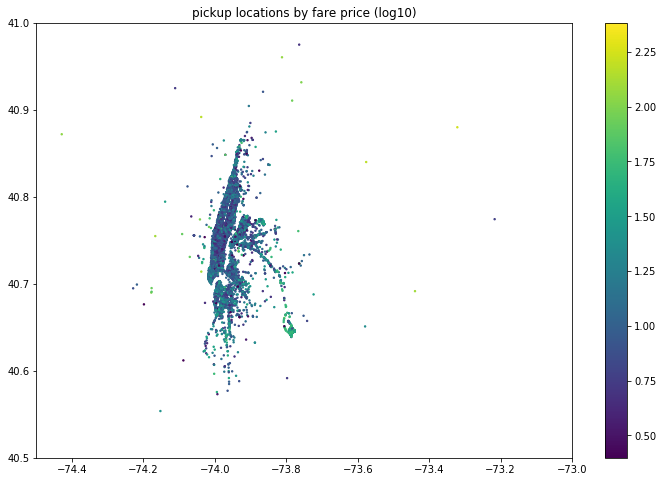

In [122]:
plt.figure(figsize=(12,8)) #x,y
sc = plt.scatter(clean_df.pickup_longitude, clean_df.pickup_latitude, c = np.log10(clean_df.fare_amount), s=2)
plt.xlim(-74.5, -73)
plt.ylim(40.5, 41.0)
plt.colorbar(sc)
plt.title('pickup locations by fare price (log10)')
plt.savefig('pickup_log10.png',dpi=250)



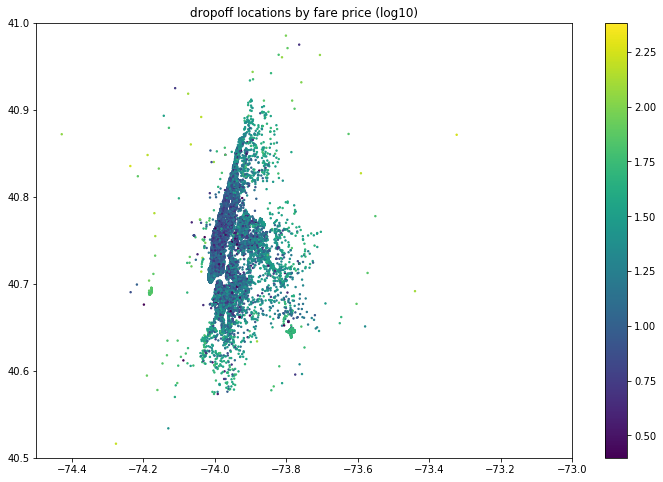

In [123]:
plt.figure(figsize=(12,8)) #x,y
sc = plt.scatter(clean_df.dropoff_longitude, clean_df.dropoff_latitude, c = np.log10(clean_df.fare_amount), s=2)
plt.xlim(-74.5, -73)
plt.ylim(40.5, 41.0)
plt.colorbar(sc)
plt.title('dropoff locations by fare price (log10)')
plt.savefig('dropoff_log10.png',dpi=250)

Text(0.5,1,'fare amounts')

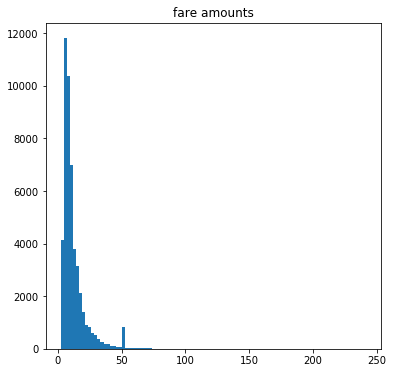

In [93]:
plt.figure(figsize=(6,6))
plt.hist(clean_df.fare_amount, bins=100);
plt.title('fare amounts')

In [110]:
import folium
from folium.plugins import HeatMap


m = folium.Map(location=[clean_df.pickup_latitude.values[1], clean_df.pickup_longitude.values[1]],
              tiles='OpenStreetMap')

heat_df = clean_df[['pickup_latitude','pickup_longitude']]
heat_data = [[row['pickup_latitude'],row['pickup_longitude']] for index, row in heat_df.iterrows()]

HeatMap(heat_data).add_to(m)

In [111]:
m

In [124]:
m = folium.Map(location=[clean_df.pickup_latitude.values[1], clean_df.pickup_longitude.values[1]],
              tiles='OpenStreetMap')

heat_df = clean_df[['dropoff_latitude','dropoff_longitude']]
heat_data = [[row['dropoff_latitude'],row['dropoff_longitude']] for index, row in heat_df.iterrows()]

HeatMap(heat_data).add_to(m)

In [125]:
m